In [1]:
from sklearn.datasets import fetch_20newsgroups
import pickle

In [2]:
categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics',
              'comp.sys.mac.hardware', 'comp.os.ms-windows.misc',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

In [3]:
# -- Get TF-IDF Matrix -- 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(min_df=3, stop_words='english')
tfidf = TfidfTransformer(smooth_idf=False)
dataset_doc_term = vectorizer.fit_transform(dataset.data)
dataset_tfidf = tfidf.fit_transform(dataset_doc_term)

print('Dimention of the TF-IDF matrix =', dataset_tfidf.shape)

Dimention of the TF-IDF matrix = (7882, 27768)


In [4]:
# -- Get K-means Cluster Prediction --
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, max_iter=2000, n_init=30, n_jobs=-1)

In [5]:
dataset_kmeans = kmeans.fit_predict(dataset_tfidf)

In [6]:
pickle.dump( dataset_kmeans, open( "project2_problem2_kmeans.p", "wb" ) )

In [7]:
#dataset_kmeans

In [8]:
# -- Calculate Contingency --
from sklearn.metrics.cluster import contingency_matrix
import numpy as np

def calculate_contingency(file, true_label, two_class, percentage):
    dataset_pred = pickle.load( open( file, "rb" ) )
    dataset_target = true_label.copy()
    if two_class == True:
        dataset_target[np.where(dataset_target<4)]=0
        dataset_target[np.where(dataset_target>=4)]=1
    if percentage == True:
        dataset_contingency = contingency_matrix(dataset_target,dataset_pred)/len(dataset_target)*100
    else:
        dataset_contingency = contingency_matrix(dataset_target,dataset_pred)    
    return dataset_target, dataset_contingency

# In percentage
dataset_target, dataset_contingency = calculate_contingency('project2_problem2_kmeans.p',
                                                            dataset.target, two_class=True, 
                                                           percentage=True)
# In number of documents
dataset_target_num, dataset_contingency_num = calculate_contingency('project2_problem2_kmeans.p',
                                                            dataset.target, two_class=True, 
                                                           percentage=False)

In [9]:
#max(dataset_kmeans)

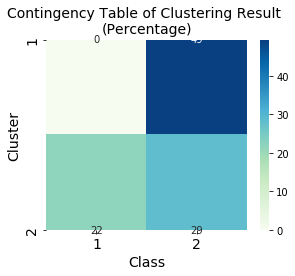

<Figure size 432x288 with 0 Axes>

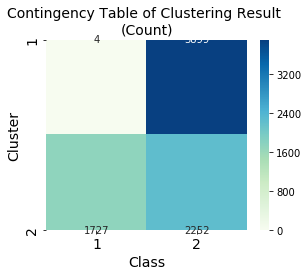

<Figure size 432x288 with 0 Axes>

In [12]:
# -- Plot Contingency Table --
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def plot_contingency_table(dataset_contingency, index, columns, subtitle, measure_scores, title, figsize=(6,5)):
    df = pd.DataFrame(dataset_contingency, 
                      index = index,
                      columns = columns)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax = sn.heatmap(df, annot=True, vmin=0.0, fmt='.0f', cmap='GnBu', center=np.max(dataset_contingency)/2)
    plt.yticks([(i+0.5) for i in range(len(index))], index, va='center', fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Cluster', fontsize=14)
    plt.title('Contingency Table of Clustering Result'+ title, fontsize=14)
    fig.text(0,0,measure_scores,bbox=dict(facecolor='red', alpha=0.3), fontsize=12)
    plt.show()
    plt.savefig('ECE219_problem2_{}.png'.format(subtitle), format='png', bbox_inches='tight')

plot_contingency_table(dataset_contingency, ['1', '2'],
                       ['1', '2'], '8 catagories','',' \n(Percentage)', figsize=(4.5,3.5),)
plot_contingency_table(dataset_contingency_num, ['1', '2'],
                       ['1', '2'], '8 catagories','',' \n(Count)',figsize=(4.5,3.5),)

Question 3: Report the 5 measures above for the K-means clustering results you get.

In [6]:
# -- Get 5 Measure Scores --
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

score = lambda true, pred: np.array([homogeneity_score(true, pred),
                                      completeness_score(true, pred),
                                      v_measure_score(true, pred),
                                      adjusted_rand_score(true, pred),
                                      adjusted_mutual_info_score(true, pred)])
print_score = lambda true, pred: ('homogeneity score: {:.4f}\ncompleteness score: {:.4f}\n'\
               'v measure score: {:.4f}\nadjusted rand score: {:.4f}\nadjusted mutual info score: {:.4f}'.format(*score(true, pred)))        

measure_score = print_score(dataset_target, pickle.load( open( 'project2_problem2_kmeans.p', "rb" ) ))
print(measure_score)
# fig,axes = plt.subplots(1,3,figsize=(13,4), dpi=300)
# axes[0].text(0,0,measure_score,bbox=dict(facecolor='green', alpha=0.2), fontsize=16)    
# axes[0].axis('off')
# axes[1].axis('off')
# axes[2].axis('off')
# plt.show()
# plt.savefig('ECE219_project2_problem3_score.png')

homogeneity score: 0.2552
completeness score: 0.3361
v measure score: 0.2901
adjusted rand score: 0.1827
adjusted mutual info score: 0.2901


QUESTION 4: Report the plot of the percent of variance the top r principle components can retain v.s. r, for r = 1 to 1000.

In [7]:
#-- Apply TruncatedSVD --
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=0)
dataset_tfidf_reduced_svd = svd.fit_transform(dataset_tfidf)
dataset_tfidf_recon_svd = svd.inverse_transform(dataset_tfidf_reduced_svd)
dataset_tfidf_comp_svd = svd.components_
#-- Plot Percent of Variance of The Top r Principle Components --
dataset_singular = svd.singular_values_
dataset_explained_var_ratio = svd.explained_variance_ratio_

Text(0, 0.5, 'cummulative percent of variance (%)')

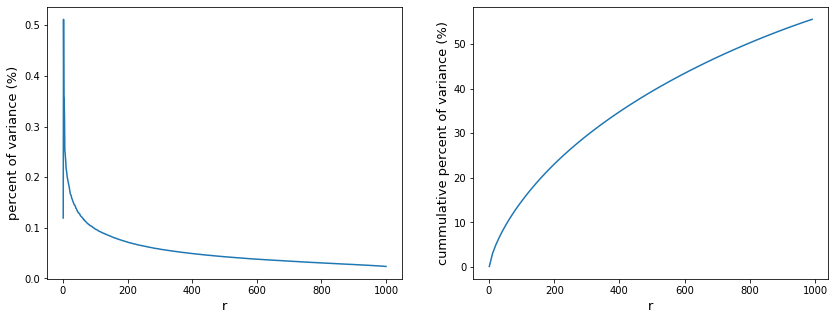

In [8]:
fig = plt.figure(figsize=(14,5))
#f,axes
plt.subplot(121)
plt.plot(np.arange(1000)+1, dataset_explained_var_ratio*100)
# plt.title('Percent of Variance of Top r Principle Components\n'\
#          'Percent of Variance of Total Top 1000 PCs = 55.74%', fontsize=13)
plt.xlabel('r', fontsize=13)
plt.ylabel('percent of variance (%)', fontsize=13)
#plt.savefig('project_2_problem4_variance_percentage.png',format='png')

#fig = plt.figure(figsize=(6,5))
plt.subplot(122)
r = np.arange(1,1000,10)
cummulative_explained_variance_ratio = [np.sum(dataset_explained_var_ratio[:r_])*100 for r_ in r]
plt.plot(r,cummulative_explained_variance_ratio)
plt.xlabel('r', fontsize=13)
plt.ylabel('cummulative percent of variance (%)', fontsize=13)

QUESTION 5:
Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1; 2; 3; 5; 10; 20; 50; 100; 300, and plot the 5 measure scores v.s. r for both SVD and NMF. Report a good choice of r for SVD and NMF respectively.
Note: In the choice of r, there is a trade-off between the information preservation, and better performance of k-means in lower dimensions.

In [20]:
#-- Function to Get and Plot 5 Measure Scores --
from sklearn.decomposition import NMF 

#pickle.dump(123, open( "project_{}_problem_{}_kmeans.p".format(99,2), "wb" ))
#pickle.load( open( "project_{}_problem_{}_kmeans.p".format(99,2), "rb" ))

def get_scores(dataset_tfidf, true_label, r_list, num_cluster, reduction_method=None):
    
    method = []
    method_pred = []
    method_score = []
    method_fit_predict = []
    method_print_score = []
    X = []
    kmeans = KMeans(n_clusters=num_cluster, random_state=0, max_iter=1000, n_init=30, n_jobs=-1)

    if reduction_method == 'SVD':
        print('Applying SVD')
        svd = TruncatedSVD(n_components=1000, random_state=0)
        #dataset_tfidf_reduced_svd.shape
        dataset_tfidf_reduced_svd = svd.fit_transform(dataset_tfidf)
        for r in list(r_list) :
            X = dataset_tfidf_reduced_svd[:,:r]
            method.append(X)

            
    if reduction_method == 'NMF':
        print('Applying NMF')
        for r in list(r_list) :
            print('NMF for r = ' + str(r)+'.')
            nmf = NMF(n_components=r, init='random', random_state=0)
            X = nmf.fit_transform(dataset_tfidf)
            method.append(X)

            
    for r in range(len(r_list)):
        print('classifying r = '+str(r)+'.')
        method_fit_predict = kmeans.fit_predict(method[r])
        method_score.append(score(true_label, method_fit_predict))
        method_print_score.append(print_score(true_label, method_fit_predict))
        method_pred.append(method_fit_predict)
        
    method_score = np.asarray(method_score)
    pickle.dump(method_score, open( "project2_problem5_{}_numcluster_{}_r_{}.p".format(reduction_method, num_cluster, r_list), "wb" ))
    #np.save('Kylie_{}_scores_{} cluster_{}.npy'.format(reduction_method, num_cluster, r_list), method_score)
    return method, method_pred

In [21]:
#-- Get 5 measure Scores For NMF And SVD --
R = [1,2,3,5,10,20,50,100,300]
# The NMF takes very long time!
NMF_reduced, NMF_pred = get_scores(dataset_tfidf, dataset_target, R, 2, reduction_method='NMF')
SVD_reduced, SVD_pred = get_scores(dataset_tfidf, dataset_target, R, 2, reduction_method='SVD')

Applying NMF
NMF for r = 1.
NMF for r = 2.
NMF for r = 3.
NMF for r = 5.
NMF for r = 10.
NMF for r = 20.
NMF for r = 50.
NMF for r = 100.
NMF for r = 300.
classifying r = 0.
classifying r = 1.
classifying r = 2.
classifying r = 3.
classifying r = 4.
classifying r = 5.
classifying r = 6.
classifying r = 7.
classifying r = 8.
Applying SVD
classifying r = 0.
classifying r = 1.
classifying r = 2.
classifying r = 3.
classifying r = 4.
classifying r = 5.
classifying r = 6.
classifying r = 7.
classifying r = 8.


In [23]:
def plot_scores(num_cluster, reduction_method, r_list, r_top, figsize=(10,4), loc='upper right'):
    
    fig = plt.figure(figsize=figsize)
    plt.clf()
    
    for i in range(5):
        plt.plot(r_top, np.load('project2_problem5_{}_numcluster_{}_r_{}.p'.format(
            reduction_method, num_cluster, r_list))[:len(r_top),i], marker=i+2)
    
    plt.legend(['homogeneity score','completeness score', 'v measure score', 
                'adjusted rand score', 'adjusted mutual info score'], loc=loc)
    plt.title('5 Measure Scores for {}'.format(reduction_method))
    plt.xlabel('r')
    plt.ylabel('score')
    plt.show()
    plt.savefig('project2_problem5_{}_numcluster_{}_r_{}'.format(reduction_method, num_cluster, r_top))

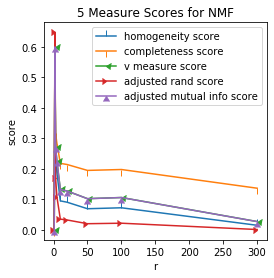

<Figure size 432x288 with 0 Axes>

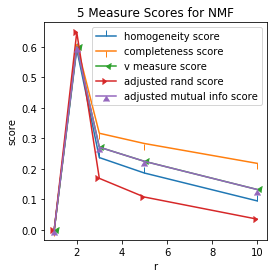

<Figure size 432x288 with 0 Axes>

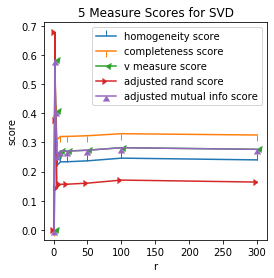

<Figure size 432x288 with 0 Axes>

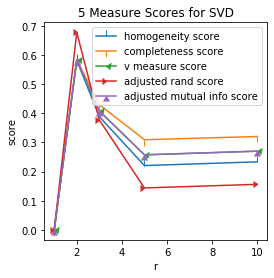

<Figure size 432x288 with 0 Axes>

In [24]:
#-- Plot 5 Measure Scores For NMF And SVD --
R = [1,2,3,5,10,20,50,100,300]
R1 = [1,2,3,5,10] 

plot_scores(num_cluster=2, reduction_method='NMF', r_list=R, r_top=R, figsize=(4,4))
plot_scores(num_cluster=2, reduction_method='NMF', r_list=R, r_top=R1,figsize=(4,4))
plot_scores(num_cluster=2, reduction_method='SVD', r_list=R, r_top=R, figsize=(4,4))
plot_scores(num_cluster=2, reduction_method='SVD', r_list=R, r_top=R1, figsize=(4,4))

QUESTION 6: How do you explain the non-monotonic behavior of the measures as r
increases?